# Aaronica 
## Team members: Mohammad Chegini, Pouya Shiri, Professor Amirali Baniasadi

## Importing libraries and fetching the data

In [1]:
import numpy as np
import torch
import pickle
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from torch import nn
import brevitas.nn as qnn
from brevitas.quant import IntBias
from brevitas.inject.enum import ScalingImplType
from brevitas.inject.defaults import Int8ActPerTensorFloatMinMaxInit
from torch.utils.data import Dataset, DataLoader
from brevitas.export.onnx.generic.manager import BrevitasONNXManager
from finn.util.inference_cost import inference_cost
import json, os, h5py, copy
import torch.nn.utils.prune as prune
from utils import load_checkpoint, plot_confusion_matrix, calculate_cost, sparsity_report
from dataset_loader import radioml_18_dataset
from network import AaronNet, get_baseline_network
import seaborn as sns
import pandas as pd
from train import test, test_over_snr

In [2]:
gpu = 0
if torch.cuda.is_available():
    torch.cuda.device(gpu)
    print("Using GPU %d" % gpu)
else:
    gpu = None
    print("Using CPU only")

Using GPU 0


In [3]:
# Setting seeds for reproducibility
torch.manual_seed(0)
np.random.seed(0)

In [4]:
# ُSpecify the dataset_path
dataset_path = "/home/aaron/5g/2018.01/GOLD_XYZ_OSC.0001_1024.hdf5"
dataset = radioml_18_dataset(dataset_path)

## Competition Baseline Model

In [5]:
VGG = get_baseline_network()

## Proposed Model

In [6]:
config_32 = {
    "conv_layers": [
        #filters, ksize, padding, w_bits, a_bits, pool, bias
        [33, 3, 1, 6, 6, 2, True],
        [32, 3, 1, 6, 6, 2, True],
        [32, 3, 1, 6, 6, 2, True],
        [32, 3, 1, 6, 6, 2, True],
        [32, 3, 1, 6, 6, 2, True],
        [40, 3, 1, 6, 6, 2, True],
    ],
    "linear_layers": [48, 6, 6, True]
}

config_48 = {
    "conv_layers": [
        #filters, ksize, padding, w_bits, a_bits, pool, bias
        [48, 3, 1, 6, 6, 2, True],
        [48, 3, 1, 6, 6, 2, True],
        [48, 3, 1, 6, 6, 2, True],
        [48, 3, 1, 6, 6, 2, True],
        [48, 3, 1, 6, 6, 2, True],
        [48, 3, 1, 6, 6, 2, True],
    ],
    "linear_layers": [48, 6, 6, True]
}

In [7]:
AaronNet32 = AaronNet(config_32, 6)
AaronNet32plus = AaronNet(config_32, 6)
AaronNet32plusplus = AaronNet(config_32, 6)

AaronNet48 = AaronNet(config_48, 6)
AaronNet48plus = AaronNet(config_48, 6)
AaronNet48plusplus = AaronNet(config_48, 6)

## Loading checkpoints for all models

In [8]:
vgg_path = "./checkpoints/vgg.pth"
AaronNet32_path = "./checkpoints/AaronNet32.pth"
AaronNet32Plus_path = "./checkpoints/AaronNet32plus.pth"
AaronNet33PlusPlus_path = "./checkpoints/AaronNet32plusplus.pth"
AaronNet48_path = "./checkpoints/AaronNet48.pth"
AaronNet48Plus_path = "./checkpoints/AaronNet48plus.pth"
AaronNet48PlusPlus_path = "./checkpoints/AaronNet48plusplus.pth"

# Load trained parameters
vgg_state = torch.load(vgg_path, map_location=torch.device("cpu"))
AaronNet32_state = torch.load(AaronNet32_path, map_location=torch.device("cpu"))
AaronNet32plus_state = torch.load(AaronNet32Plus_path, map_location=torch.device("cpu"))
AaronNet32plusplus_state = torch.load(AaronNet33PlusPlus_path, map_location=torch.device("cpu"))
AaronNet48_state = torch.load(AaronNet48_path, map_location=torch.device("cpu"))
AaronNet48plus_state = torch.load(AaronNet48Plus_path, map_location=torch.device("cpu"))
AaronNet48plusplus_state = torch.load(AaronNet48PlusPlus_path, map_location=torch.device("cpu"))

VGG.load_state_dict(vgg_state)

AaronNet32.load_state_dict(AaronNet32_state)
AaronNet32plus.load_state_dict(AaronNet32plus_state)
AaronNet32plusplus.load_state_dict(AaronNet32plusplus_state)

AaronNet48.load_state_dict(AaronNet48_state)
AaronNet48plus.load_state_dict(AaronNet48plus_state)
AaronNet48plusplus.load_state_dict(AaronNet48plusplus_state)

if gpu is not None:
    VGG = VGG.cuda()
    AaronNet32 = AaronNet32.cuda()
    AaronNet32plus = AaronNet32plus.cuda()
    AaronNet32plusplus = AaronNet32plusplus.cuda()
    AaronNet48 = AaronNet48.cuda()
    AaronNet48plus = AaronNet48plus.cuda()
    AaronNet48plusplus = AaronNet48plusplus.cuda()
print("Weights loaded successfully")

Weights loaded successfully


## Evaluating models over all SNRs

In [9]:
batch_size = 1024
dataset = radioml_18_dataset(dataset_path)
data_loader_test = DataLoader(dataset, batch_size=batch_size, sampler=dataset.test_sampler)

In [10]:
acc_VGG = test(VGG, data_loader_test, 0)
acc_AaronNet32 = test(AaronNet32, data_loader_test, 0)
acc_AaronNet48 = test(AaronNet48, data_loader_test, 0)
acc_AaronNet32plus = test(AaronNet32plus, data_loader_test, 0)
acc_AaronNet48plus = test(AaronNet48plus, data_loader_test, 0)
acc_AaronNet32plusplus = test(AaronNet32plusplus, data_loader_test, 0)
acc_AaronNet48plusplus = test(AaronNet48plusplus, data_loader_test, 0)


print(f"VGG Accuracy across all SNRs: {acc_VGG}")
print(f"AaronNet32 Accuracy across all SNRs: {acc_AaronNet32}")
print(f"AaronNet48 Accuracy across all SNRs: {acc_AaronNet48}")
print(f"AaronNet32+ Accuracy across all SNRs: {acc_AaronNet32plus}")
print(f"AaronNet48+ Accuracy across all SNRs: {acc_AaronNet48plus}")
print(f"AaronNet32++ Accuracy across all SNRs: {acc_AaronNet32plusplus}")
print(f"AaronNet48++ Accuracy across all SNRs: {acc_AaronNet48plusplus}")

VGG Accuracy across all SNRs: 0.5946685428392745
AaronNet32 Accuracy across all SNRs: 0.5849710756722952
AaronNet48 Accuracy across all SNRs: 0.5960678549093184
AaronNet32+ Accuracy across all SNRs: 0.5831261726078799
AaronNet48+ Accuracy across all SNRs: 0.6007387429643527
AaronNet32++ Accuracy across all SNRs: 0.5608935272045028
AaronNet48++ Accuracy across all SNRs: 0.5704659161976235


## Evaluating models on different SNRs

In [11]:
# َage in ok beshe aslan niazi b balaee nist

y_exp = np.empty((0))
y_snr = np.empty((0))

y_pred_VGG = np.empty((0, len(dataset.mod_classes)))
y_pred_AaronNet32 = np.empty((0, len(dataset.mod_classes)))
y_pred_AaronNet32plus = np.empty((0, len(dataset.mod_classes)))
y_pred_AaronNet32plusplus = np.empty((0, len(dataset.mod_classes)))
y_pred_AaronNet48 = np.empty((0, len(dataset.mod_classes)))
y_pred_AaronNet48plus = np.empty((0, len(dataset.mod_classes)))
y_pred_AaronNet48plusplus = np.empty((0, len(dataset.mod_classes)))

VGG.eval()
AaronNet32.eval()
AaronNet32plus.eval()
AaronNet32plusplus.eval()
AaronNet32.eval()
AaronNet32plus.eval()
AaronNet32plusplus.eval()


with torch.no_grad():
    for data in tqdm(data_loader_test, desc="Batches"):
        inputs, target, snr = data
        if gpu is not None:
            inputs = inputs.cuda()
        output_VGG = VGG(inputs)
        output_AaronNet32 = AaronNet32(inputs)
        output_AaronNet48 = AaronNet48(inputs)
        output_AaronNet32plus = AaronNet32plus(inputs)
        output_AaronNet48plus = AaronNet48plus(inputs)
        output_AaronNet32plusplus = AaronNet32plusplus(inputs)
        output_AaronNet48plusplus = AaronNet48plusplus(inputs)
        
        y_pred_VGG = np.concatenate((y_pred_VGG, output_VGG.cpu()))
        y_pred_AaronNet32 = np.concatenate((y_pred_AaronNet32, output_AaronNet32.cpu()))
        y_pred_AaronNet48 = np.concatenate((y_pred_AaronNet48, output_AaronNet48.cpu()))
        y_pred_AaronNet32plus = np.concatenate((y_pred_AaronNet32plus, output_AaronNet32plus.cpu()))
        y_pred_AaronNet48plus = np.concatenate((y_pred_AaronNet48plus, output_AaronNet48plus.cpu()))
        y_pred_AaronNet32plusplus = np.concatenate((y_pred_AaronNet32plusplus, output_AaronNet32plusplus.cpu()))
        y_pred_AaronNet48plusplus = np.concatenate((y_pred_AaronNet48plusplus, output_AaronNet48plusplus.cpu()))
        
        y_exp = np.concatenate((y_exp,target))
        y_snr = np.concatenate((y_snr,snr))
        
print("Evaluation Done!")

Batches:   0%|          | 0/250 [00:00<?, ?it/s]

Evaluation Done!


In [12]:
VGG_accs = []
AaronNet32_accs = []
AaronNet32plus_accs = []
AaronNet32plusplus_accs = []
AaronNet48_accs = []
AaronNet48plus_accs = []
AaronNet48plusplus_accs = []


for snr in dataset.snr_classes:
    indices_snr = (y_snr == snr).nonzero()
    
    VGG_accs.append(test_over_snr(y_exp, y_pred_VGG, indices_snr, dataset))
    AaronNet32_accs.append(test_over_snr(y_exp, y_pred_AaronNet32, indices_snr, dataset))
    AaronNet48_accs.append(test_over_snr(y_exp, y_pred_AaronNet48, indices_snr, dataset))
    AaronNet32plus_accs.append(test_over_snr(y_exp, y_pred_AaronNet32plus, indices_snr, dataset))
    AaronNet48plus_accs.append(test_over_snr(y_exp, y_pred_AaronNet48plus, indices_snr, dataset))
    AaronNet32plusplus_accs.append(test_over_snr(y_exp, y_pred_AaronNet32plusplus, indices_snr, dataset))
    AaronNet48plusplus_accs.append(test_over_snr(y_exp, y_pred_AaronNet48plusplus, indices_snr, dataset))

## Accuracy vs SNR of AaronNet32

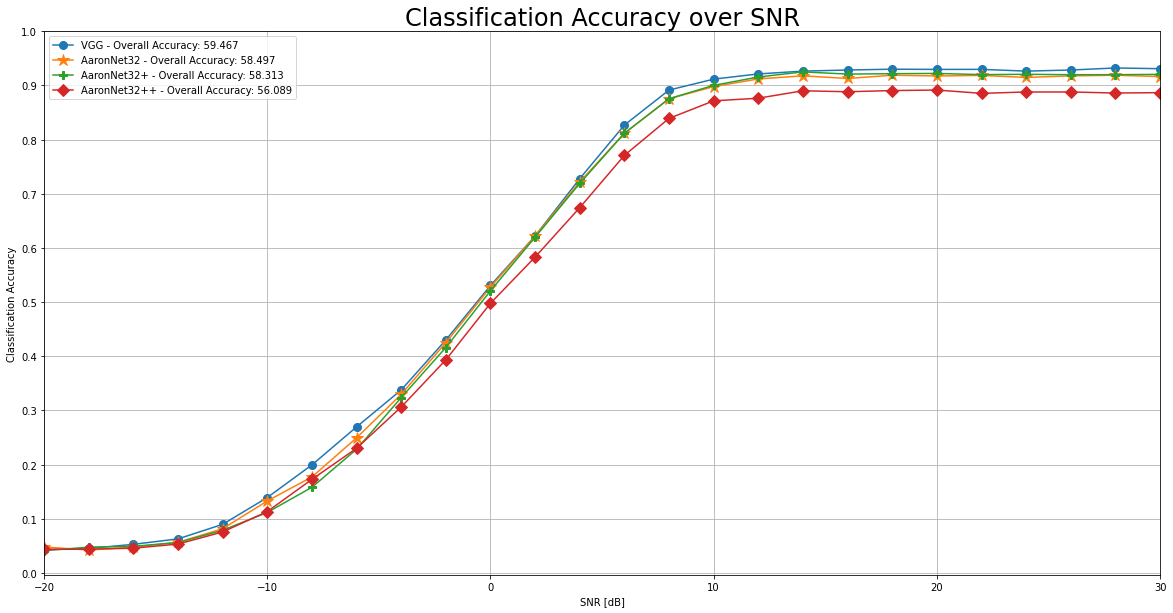

In [13]:
plt.figure(figsize=(20,10))
plt.plot(dataset.snr_classes, VGG_accs, marker='o', markersize=8)
plt.plot(dataset.snr_classes, AaronNet32_accs, marker='*', markersize=12)
plt.plot(dataset.snr_classes, AaronNet32plus_accs, marker='P', markersize=8)
plt.plot(dataset.snr_classes, AaronNet32plusplus_accs, marker='D', markersize=8)
plt.legend([
    f"VGG - Overall Accuracy: {np.mean(VGG_accs)*100:0.3f}",
    f"AaronNet32 - Overall Accuracy: {np.mean(AaronNet32_accs)*100:0.3f}",
    f"AaronNet32+ - Overall Accuracy: {np.mean(AaronNet32plus_accs)*100:0.3f}",
    f"AaronNet32++ - Overall Accuracy: {np.mean(AaronNet32plusplus_accs)*100:0.3f}"])
plt.rcParams.update({'font.size': 20})
plt.xlabel("SNR [dB]")
plt.xlim([-20, 30])
plt.ylabel("Classification Accuracy")
plt.yticks(np.arange(0, 1.1, 0.1))
plt.title("Classification Accuracy over SNR")
plt.grid()
plt.title("Classification Accuracy over SNR")
plt.show()

## Accuracy vs SNR of AaronNet48

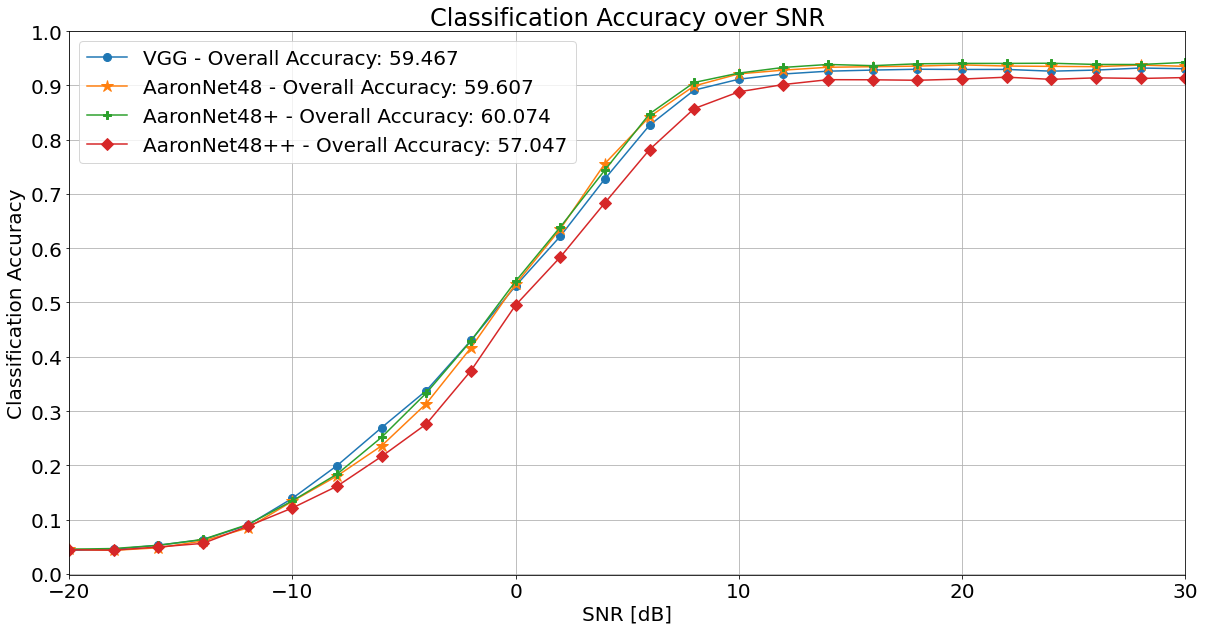

In [14]:
plt.figure(figsize=(20,10))
plt.plot(dataset.snr_classes, VGG_accs, marker='o', markersize=8)
plt.plot(dataset.snr_classes, AaronNet48_accs, marker='*', markersize=12)
plt.plot(dataset.snr_classes, AaronNet48plus_accs, marker='P', markersize=8)
plt.plot(dataset.snr_classes, AaronNet48plusplus_accs, marker='D', markersize=8)
plt.rcParams.update({'font.size': 20})
plt.legend([
    f"VGG - Overall Accuracy: {np.mean(VGG_accs)*100:0.3f}",
    f"AaronNet48 - Overall Accuracy: {np.mean(AaronNet48_accs)*100:0.3f}",
    f"AaronNet48+ - Overall Accuracy: {np.mean(AaronNet48plus_accs)*100:0.3f}",
    f"AaronNet48++ - Overall Accuracy: {np.mean(AaronNet48plusplus_accs)*100:0.3f}"
])
plt.xlabel("SNR [dB]")
plt.xlim([-20, 30])
plt.ylabel("Classification Accuracy")
plt.yticks(np.arange(0, 1.1, 0.1))
plt.title("Classification Accuracy over SNR")
plt.grid()
plt.title("Classification Accuracy over SNR")
plt.show()

## Accuracy vs SNR of best in cases (Highest Acc, Highest Compression and Baseline)

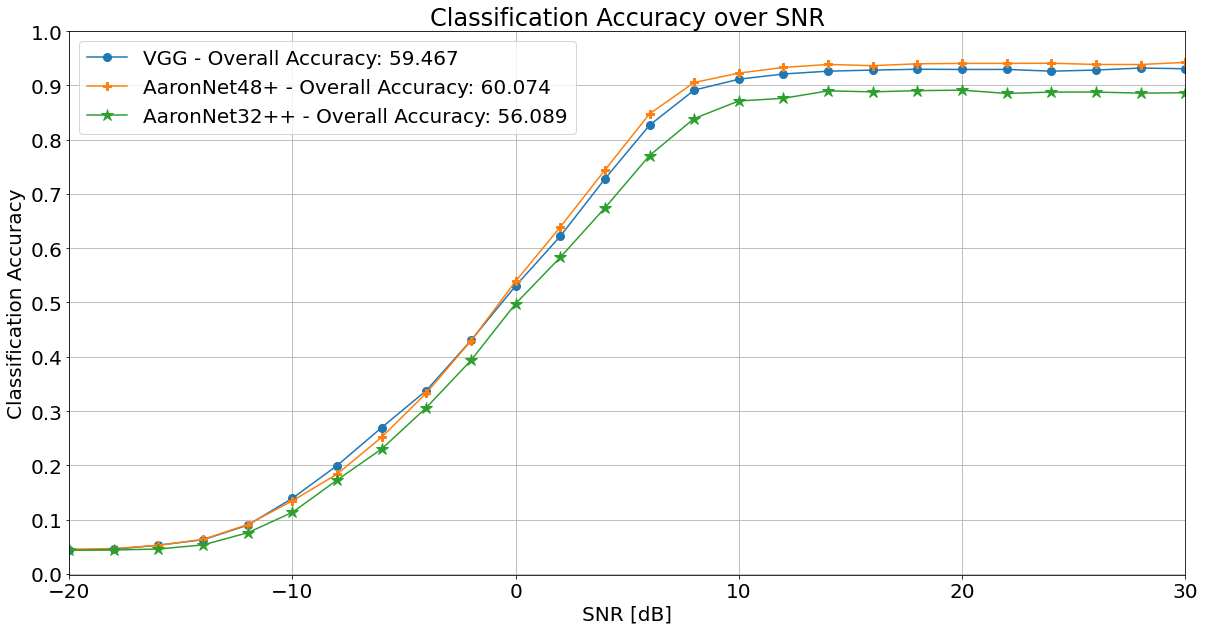

In [15]:
plt.figure(figsize=(20,10))
plt.plot(dataset.snr_classes, VGG_accs, marker='o', markersize=8)
plt.plot(dataset.snr_classes, AaronNet48plus_accs, marker='P', markersize=8)
plt.plot(dataset.snr_classes, AaronNet32plusplus_accs, marker='*', markersize=12)
plt.rcParams.update({'font.size': 20})
plt.legend([
    f"VGG - Overall Accuracy: {np.mean(VGG_accs)*100:0.3f}",
    f"AaronNet48+ - Overall Accuracy: {np.mean(AaronNet48plus_accs)*100:0.3f}",
    f"AaronNet32++ - Overall Accuracy: {np.mean(AaronNet32plusplus_accs)*100:0.3f}",
])
plt.xlabel("SNR [dB]")
plt.xlim([-20, 30])
plt.ylabel("Classification Accuracy")
plt.yticks(np.arange(0, 1.1, 0.1))
plt.title("Classification Accuracy over SNR")
plt.grid()
plt.title("Classification Accuracy over SNR")
plt.show()

## Cost calculation of different models

In [16]:
print("VGG -- Baseline Competition")
VGGBops, VGGWBits, VGGCost = calculate_cost(VGG, "vgg")

VGG -- Baseline Competition
Inference cost for ./Models/vgg_export.onnx
{
  "discount_sparsity": true,
  "mem_o_FLOAT32": 130328.0,
  "mem_w_SCALEDINT8": 155617.0,
  "op_mac_SCALEDINT8_SCALEDINT8": 388096.0,
  "op_mac_SCALEDUINT8_SCALEDINT8": 12232215.0,
  "total_bops": 807699904.0,
  "total_mem_o_bits": 4170496.0,
  "total_mem_w_bits": 1244936.0,
  "unsupported": "set()"
}
Ops is 0.5, w_bits is 0.5
Normalized inference cost score: 1.000000


In [17]:
print("AaronNet32 -- Baseline")
AaronNet32Bops, AaronNet32WBits, AaronNet32Cost = calculate_cost(AaronNet32, "AaronNet32")

AaronNet32 -- Baseline
Inference cost for ./Models/AaronNet32_export.onnx
{
  "discount_sparsity": true,
  "mem_o_FLOAT32": 49275.0,
  "mem_w_SCALEDINT6": 12491.0,
  "op_mac_FLOAT32_SCALEDINT6": 47548.0,
  "op_mac_SCALEDINT6_SCALEDINT6": 406060.0,
  "op_mac_SCALEDUINT6_SCALEDINT6": 557462.0,
  "total_bops": 43816008.0,
  "total_mem_o_bits": 1576800.0,
  "total_mem_w_bits": 74946.0,
  "unsupported": "{'GlobalMaxPool'}"
}
Ops is 0.02712394032920425, w_bits is 0.030100342507566654
Normalized inference cost score: 0.057224


In [18]:
print("AaronNet32+ -- AaronNet32 Slightly Pruned")
AaronNet32plusBops, AaronNet32plusWBits, AaronNet32plusCost = calculate_cost(AaronNet32plus, "AaronNet32plus")

AaronNet32+ -- AaronNet32 Slightly Pruned
Inference cost for ./Models/AaronNet32plus_export.onnx
{
  "discount_sparsity": true,
  "mem_o_FLOAT32": 49275.0,
  "mem_w_SCALEDINT6": 6794.0,
  "op_mac_FLOAT32_SCALEDINT6": 34584.0,
  "op_mac_SCALEDINT6_SCALEDINT6": 222562.0,
  "op_mac_SCALEDUINT6_SCALEDINT6": 236421.0,
  "total_bops": 23163516.0,
  "total_mem_o_bits": 1576800.0,
  "total_mem_w_bits": 40764.0,
  "unsupported": "{'GlobalMaxPool'}"
}
Ops is 0.014339184569223373, w_bits is 0.01637192594639403
Normalized inference cost score: 0.030711


In [19]:
print("AaronNet32++ -- AaronNet32 Slightly Pruned")
AaronNet32plusplusBops, AaronNet32plusplusWBits, AaronNet32plusplusCost = calculate_cost(AaronNet32plusplus, "AaronNet32plusplus")

AaronNet32++ -- AaronNet32 Slightly Pruned
Inference cost for ./Models/AaronNet32plusplus_export.onnx
{
  "discount_sparsity": true,
  "mem_o_FLOAT32": 49275.0,
  "mem_w_SCALEDINT6": 3160.0,
  "op_mac_FLOAT32_SCALEDINT6": 24889.0,
  "op_mac_SCALEDINT6_SCALEDINT6": 114622.0,
  "op_mac_SCALEDUINT6_SCALEDINT6": 115660.0,
  "total_bops": 13068840.0,
  "total_mem_o_bits": 1576800.0,
  "total_mem_w_bits": 18960.0,
  "unsupported": "{'GlobalMaxPool'}"
}
Ops is 0.008090158198161678, w_bits is 0.007614849277392572
Normalized inference cost score: 0.015705


In [20]:
print("AaronNet48 -- Baseline")
AaronNet48Bops, AaronNet48WBits, AaronNet48Cost = calculate_cost(AaronNet48, "AaronNet48")

AaronNet48 -- Baseline
Inference cost for ./Models/AaronNet48_export.onnx
{
  "discount_sparsity": true,
  "mem_o_FLOAT32": 72504.0,
  "mem_w_SCALEDINT6": 19747.0,
  "op_mac_FLOAT32_SCALEDINT6": 70269.0,
  "op_mac_SCALEDINT6_SCALEDINT6": 595983.0,
  "op_mac_SCALEDUINT6_SCALEDINT6": 1222468.0,
  "total_bops": 78955884.0,
  "total_mem_o_bits": 2320128.0,
  "total_mem_w_bits": 118482.0,
  "unsupported": "{'GlobalMaxPool'}"
}
Ops is 0.04887699231421476, w_bits is 0.047585578696414915
Normalized inference cost score: 0.096463


In [21]:
print("AaronNet48+ -- AaronNet48 Slightly Pruned")
AaronNet48plusBops, AaronNet48plusWBits, AaronNet48plusCost = calculate_cost(AaronNet48plus, "AaronNet48plus")

AaronNet48+ -- AaronNet48 Slightly Pruned
Inference cost for ./Models/AaronNet48plus_export.onnx
{
  "discount_sparsity": true,
  "mem_o_FLOAT32": 72504.0,
  "mem_w_SCALEDINT6": 8667.0,
  "op_mac_FLOAT32_SCALEDINT6": 46246.0,
  "op_mac_SCALEDINT6_SCALEDINT6": 304545.0,
  "op_mac_SCALEDUINT6_SCALEDINT6": 450443.0,
  "total_bops": 36058800.0,
  "total_mem_o_bits": 2320128.0,
  "total_mem_w_bits": 52002.0,
  "unsupported": "{'GlobalMaxPool'}"
}
Ops is 0.022321904349266827, w_bits is 0.02088541097694982
Normalized inference cost score: 0.043207


In [22]:
print("AaronNet48++ -- AaronNet48 Highly pruned")
AaronNet48plusplusBops, AaronNet48plusplusWBits, AaronNet48plusplusCost = calculate_cost(AaronNet48plusplus, "AaronNet48plusplus")

AaronNet48++ -- AaronNet48 Highly pruned
Inference cost for ./Models/AaronNet48plusplus_export.onnx
{
  "discount_sparsity": true,
  "mem_o_FLOAT32": 72504.0,
  "mem_w_SCALEDINT6": 4439.0,
  "op_mac_FLOAT32_SCALEDINT6": 33842.0,
  "op_mac_SCALEDINT6_SCALEDINT6": 170134.0,
  "op_mac_SCALEDUINT6_SCALEDINT6": 228298.0,
  "total_bops": 20841216.0,
  "total_mem_o_bits": 2320128.0,
  "total_mem_w_bits": 26634.0,
  "unsupported": "{'GlobalMaxPool'}"
}
Ops is 0.012901583804075826, w_bits is 0.01069693542479292
Normalized inference cost score: 0.023599


## Comparing Inference Cost

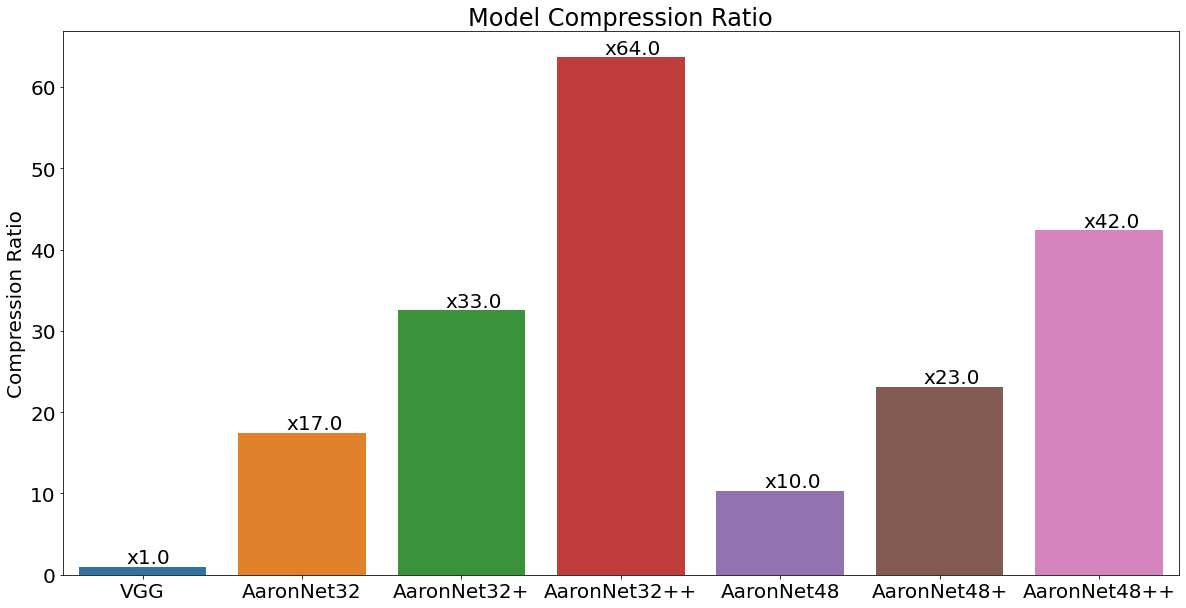

In [23]:
all_costs = np.array([
    VGGCost, AaronNet32Cost,
    AaronNet32plusCost, AaronNet32plusplusCost,
    AaronNet48Cost, AaronNet48plusCost, AaronNet48plusplusCost
]).reshape((1, -1))

all_accs = np.array([
    np.mean(VGG_accs)*100, np.mean(AaronNet32_accs)*100,
    np.mean(AaronNet32plus_accs)*100, np.mean(AaronNet32plusplus_accs)*100,
    np.mean(AaronNet48_accs)*100, np.mean(AaronNet48plus_accs)*100, np.mean(AaronNet48plusplus_accs)*100
]).reshape(1, -1)

classes = ["VGG", "AaronNet32", "AaronNet32+", "AaronNet32++", "AaronNet48", "AaronNet48+", "AaronNet48++"]
plt.rcParams.update({'font.size': 20})
plt.figure(figsize=(20, 10))
plt.title("Model Compression Ratio")
plt.ylabel("Compression Ratio")
ax = sns.barplot(x=classes, y=1.0/all_costs.reshape(-1, ))
for p in ax.patches:
    ax.annotate(f"x{np.round(p.get_height())}", (p.get_x() + 0.3, p.get_height() + 0.40))
plt.show()

## Cost vs Accuracy

In [24]:
df = pd.DataFrame(np.vstack((all_accs, 1.0/all_costs)).T, columns=["Overall Accuracy", "Compression Ratio"])
df["Names"] = classes
df[["Names", "Overall Accuracy", "Compression Ratio"]]

,Names,Overall Accuracy,Compression Ratio
0,VGG,59.466854,1.000000
1,AaronNet32,58.497108,17.475099
2,AaronNet32+,58.312617,32.561506
3,AaronNet32++,56.089353,63.673959
4,AaronNet48,59.606785,10.366715
5,AaronNet48+,60.073874,23.144229
6,AaronNet48++,57.046592,42.375540


# Gaining insight into sparsity 

In [25]:
sparsity_report(VGG)

Global sparsity is: 0.0


Total number of parameters is 159104.0
Total number of parameters after pruning is 159104.0





In [26]:
sparsity_report(AaronNet48)

Global sparsity is: 0.0


Total number of parameters is 21200.0
Total number of parameters after pruning is 21200.0





In [27]:
sparsity_report(AaronNet48plus)

Global sparsity is: 0.5904245283018867


Total number of parameters is 21200.0
Total number of parameters after pruning is 8683.0





In [28]:
sparsity_report(AaronNet48plusplus)

Global sparsity is: 0.7902830188679245


Total number of parameters is 21200.0
Total number of parameters after pruning is 4446.0





In [29]:
sparsity_report(AaronNet32)

Global sparsity is: 0.0


Total number of parameters is 13302.0
Total number of parameters after pruning is 13302.0





In [30]:
sparsity_report(AaronNet32plus)

Global sparsity is: 0.48797173357389867


Total number of parameters is 13302.0
Total number of parameters after pruning is 6811.0





In [31]:
sparsity_report(AaronNet32plusplus, True)

Global sparsity is: 0.7624417380844986


Total number of parameters is 13302.0
Total number of parameters after pruning is 3160.0



Sparsity in expand.branch1.0.weight is 73.153409%
Sparsity in expand.branch1.3.weight is 76.033058%
Sparsity in expand.branch2.0.weight is 73.426573%
Sparsity in expand.branch2.3.weight is 81.818182%
Sparsity in expand.branch3.0.weight is 73.484848%
Sparsity in expand.branch3.3.weight is 71.900826%
Sparsity in feats.0.block.0.weight is 50.505051%
Sparsity in feats.0.block.3.weight is 80.776515%
Sparsity in feats.1.block.0.weight is 51.041667%
Sparsity in feats.1.block.3.weight is 83.691406%
Sparsity in feats.2.block.0.weight is 51.041667%
Sparsity in feats.2.block.3.weight is 85.937500%
Sparsity in feats.3.block.0.weight is 42.708333%
Sparsity in feats.3.block.3.weight is 82.714844%
Sparsity in feats.4.block.0.weight is 32.291667%
Sparsity in feats.4.block.3.weight is 78.203125%
Sparsity in classifier.0.weight is 75.416667%
Sparsity in classifier.3.weight